In [1]:
import scanpy as sc
import gseapy as gp
import matplotlib.pyplot as plt
import gseapy as gp
import anndata as ad
import decoupler
from pathlib import Path

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
split = 4

In [3]:
adata_pred_ood = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/adata_ood_with_predictions_{split}.h5ad")
#adata_pred_test = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/adata_test_with_predictions_{split}.h5ad")

In [4]:
adata_pred_ood.X = adata_pred_ood.layers["X_recon_pred"]
#adata_pred_test.X = adata_pred_test.layers["X_recon_pred"]

In [5]:
adata_train_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_train_{split}.h5ad"
adata_test_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_test_{split}.h5ad"
adata_ood_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood_{split}.h5ad"

In [6]:
adata_train = sc.read(adata_train_path)
adata_test = sc.read(adata_test_path)
adata_ood = sc.read(adata_ood_path)

In [7]:
adata_pred_ood = adata_pred_ood[adata_pred_ood.obs["condition"]!="control"]

In [8]:
adata_pred_ood.var_names = adata_ood.var_names
#adata_pred_test.var_names = adata_test.var_names

In [9]:
adata_pred_ood.obs["condition"] = adata_pred_ood.obs.apply(lambda x: x["condition"] + "_pred", axis=1)

In [10]:
adata_full = ad.concat((adata_train, adata_ood, adata_pred_ood))

In [11]:
if not Path("c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
    !wget -O 'c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771

In [12]:
import pandas as pd
def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )



In [13]:
reactome = gmt_to_decoupler("c2.cp.reactome.v7.5.1.symbols.gmt")

In [14]:
# Retrieving via python
msigdb = decoupler.get_resource("MSigDB")

# Get reactome pathways
reactome = msigdb.query("collection == 'reactome_pathways'")
# Filter duplicates
reactome = reactome[~reactome.duplicated(("geneset", "genesymbol"))]


  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/connectionpool.py", line 466, in _make_request
    self._validate_conn(conn)
  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/connectionpool.py", line 1095, in _validate_conn
    conn.connect()
  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/connection.py", line 652, in connect
    sock_and_verified = _ssl_wrap_socket_and_match_hostname(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/connection.py", line 805, in _ssl_wrap_socket_and_match_hostname
    ssl_sock = ssl_wrap_socket(
               ^^^^^^^^^^^^^^^^
  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/util/ssl_.py", line 465, in ssl_wrap_socket
    ssl_sock = _ssl_wrap_socket_impl(sock, context, tls_in_tls, server_hostnam

In [15]:
sc.tl.rank_genes_groups(adata_full, "condition", method="t-test", key_added="t-test", reference="control")

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning:

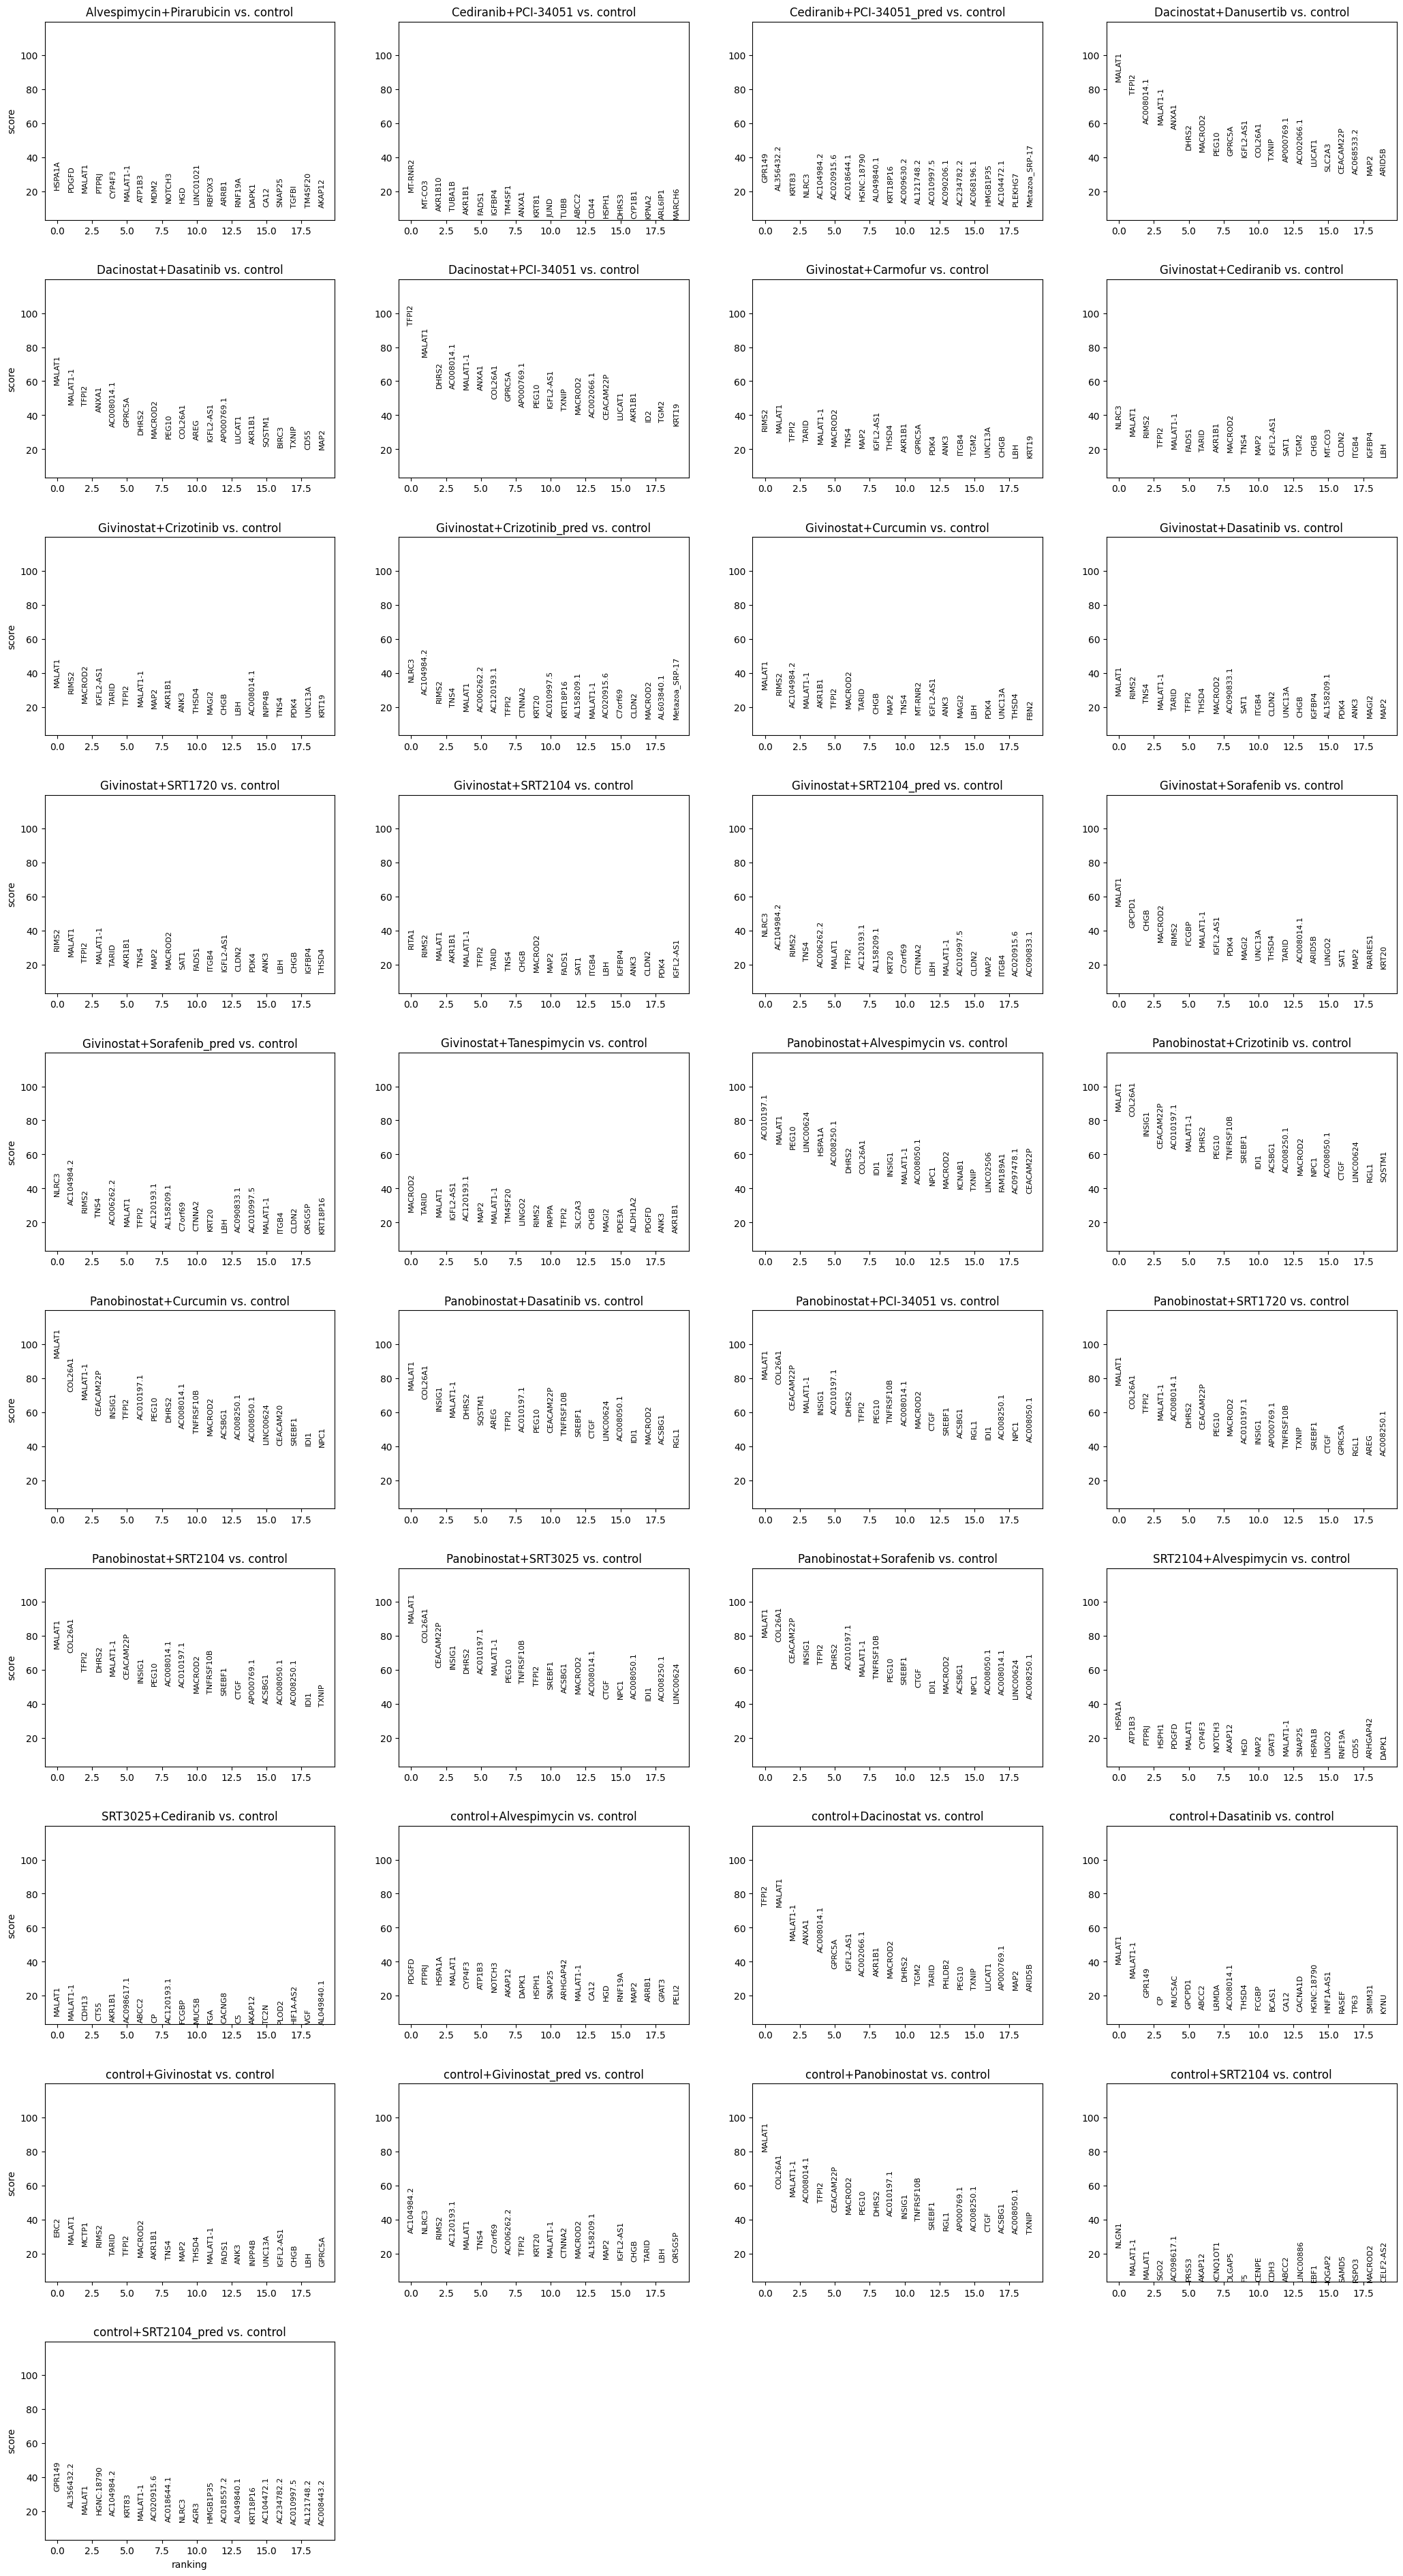

In [16]:
sc.pl.rank_genes_groups(adata_full, key="t-test")

In [17]:
import numpy as np
dict_t_stats = {}

for condition in adata_full.obs["condition"].cat.categories:
    if condition=="control":
        continue
    t_stats = (
        # Get dataframe of DE results for condition vs. rest
        sc.get.rank_genes_groups_df(adata_full, group=condition,  key="t-test")
        .set_index("names")
        # Sort by absolute score
        .sort_values("scores", key=np.abs, ascending=False)
        # Format for decoupler
        [["scores"]]
    )
    dict_t_stats[condition] = t_stats

In [18]:
# Filtering genesets to match behaviour of fgsea
geneset_size = reactome.groupby("geneset").size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]

/tmp/ipykernel_4011624/1613302725.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  geneset_size = reactome.groupby("geneset").size()


In [19]:
dict_gsea_results = {}

for condition, t_stats in dict_t_stats.items():
    scores, norm, pvals = decoupler.run_gsea(
        t_stats.T,
        reactome[reactome["geneset"].isin(gsea_genesets)],
        source="geneset",
        target="genesymbol",
    )
    gsea_results = (
        pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
        .droplevel(level=1, axis=1)
        .sort_values("pval")
    )
    dict_gsea_results[condition] = gsea_results



In [20]:
dict_gsea_results.keys()

dict_keys(['Alvespimycin+Pirarubicin', 'Cediranib+PCI-34051', 'Cediranib+PCI-34051_pred', 'Dacinostat+Danusertib', 'Dacinostat+Dasatinib', 'Dacinostat+PCI-34051', 'Givinostat+Carmofur', 'Givinostat+Cediranib', 'Givinostat+Crizotinib', 'Givinostat+Crizotinib_pred', 'Givinostat+Curcumin', 'Givinostat+Dasatinib', 'Givinostat+SRT1720', 'Givinostat+SRT2104', 'Givinostat+SRT2104_pred', 'Givinostat+Sorafenib', 'Givinostat+Sorafenib_pred', 'Givinostat+Tanespimycin', 'Panobinostat+Alvespimycin', 'Panobinostat+Crizotinib', 'Panobinostat+Curcumin', 'Panobinostat+Dasatinib', 'Panobinostat+PCI-34051', 'Panobinostat+SRT1720', 'Panobinostat+SRT2104', 'Panobinostat+SRT3025', 'Panobinostat+Sorafenib', 'SRT2104+Alvespimycin', 'SRT3025+Cediranib', 'control+Alvespimycin', 'control+Dacinostat', 'control+Dasatinib', 'control+Givinostat', 'control+Givinostat_pred', 'control+Panobinostat', 'control+SRT2104', 'control+SRT2104_pred'])

In [21]:
dict_gsea_results['Alvespimycin+Pirarubicin']

,score,norm,pval
source,,,
REACTOME_S_PHASE,-0.910354,-1.728066,0.000000
REACTOME_RESOLUTION_OF_D_LOOP_STRUCTURES_THROUGH_SYNTHESIS_DEPENDENT_STRAND_ANNEALING_SDSA,-0.953342,-1.679483,0.000000
REACTOME_RESOLUTION_OF_SISTER_CHROMATID_COHESION,-0.900444,-1.981743,0.000000
REACTOME_MITOTIC_G1_PHASE_AND_G1_S_TRANSITION,-0.892251,-1.885948,0.000000
REACTOME_MITOTIC_G2_G2_M_PHASES,-0.886004,-1.881333,0.000000
...,...,...,...
REACTOME_DEGRADATION_OF_THE_EXTRACELLULAR_MATRIX,0.229731,0.618298,0.932203
REACTOME_COLLAGEN_BIOSYNTHESIS_AND_MODIFYING_ENZYMES,-0.275848,-0.581414,0.937908
REACTOME_POST_TRANSLATIONAL_MODIFICATION_SYNTHESIS_OF_GPI_ANCHORED_PROTEINS,-0.231297,-0.470227,0.970199


In [22]:
[el for el in dict_gsea_results['Alvespimycin+Pirarubicin'].index if "TP53" in el]

['REACTOME_TRANSCRIPTIONAL_REGULATION_BY_TP53',
 'REACTOME_REGULATION_OF_TP53_ACTIVITY_THROUGH_PHOSPHORYLATION',
 'REACTOME_REGULATION_OF_TP53_ACTIVITY']

In [23]:
'REACTOME_REGULATION_OF_TP53_ACTIVITY' # 'Alvespimycin+Pirarubicin'
'REACTOME_REGULATION_OF_TP53_ACTIVITY' # maybe even more interesting, as it's for 'Givinostat+Tanespimycin' and 'Alvespimycin+Pirarubicin'
'REACTOME_TRANSCRIPTIONAL_REGULATION_BY_TP53' # affects many conditions, a bit random

'REACTOME_TRANSCRIPTIONAL_REGULATION_BY_TP53'

In [24]:
dict_gsea_results['Alvespimycin+Pirarubicin']

,score,norm,pval
source,,,
REACTOME_S_PHASE,-0.910354,-1.728066,0.000000
REACTOME_RESOLUTION_OF_D_LOOP_STRUCTURES_THROUGH_SYNTHESIS_DEPENDENT_STRAND_ANNEALING_SDSA,-0.953342,-1.679483,0.000000
REACTOME_RESOLUTION_OF_SISTER_CHROMATID_COHESION,-0.900444,-1.981743,0.000000
REACTOME_MITOTIC_G1_PHASE_AND_G1_S_TRANSITION,-0.892251,-1.885948,0.000000
REACTOME_MITOTIC_G2_G2_M_PHASES,-0.886004,-1.881333,0.000000
...,...,...,...
REACTOME_DEGRADATION_OF_THE_EXTRACELLULAR_MATRIX,0.229731,0.618298,0.932203
REACTOME_COLLAGEN_BIOSYNTHESIS_AND_MODIFYING_ENZYMES,-0.275848,-0.581414,0.937908
REACTOME_POST_TRANSLATIONAL_MODIFICATION_SYNTHESIS_OF_GPI_ANCHORED_PROTEINS,-0.231297,-0.470227,0.970199


In [25]:
res = {}
res_score = {}
res_norm = {}
for cond, df in dict_gsea_results.items():
    res[cond] = df.loc['REACTOME_REGULATION_OF_TP53_ACTIVITY_THROUGH_PHOSPHORYLATION']["pval"]
    res_score[cond] = df.loc['REACTOME_REGULATION_OF_TP53_ACTIVITY_THROUGH_PHOSPHORYLATION']["score"]
    res_norm[cond] = df.loc['REACTOME_REGULATION_OF_TP53_ACTIVITY_THROUGH_PHOSPHORYLATION']["norm"]

In [55]:
res

{'Alvespimycin+Pirarubicin': 0.05940594,
 'Cediranib+PCI-34051': 0.29848692,
 'Cediranib+PCI-34051_pred': 0.0,
 'Dacinostat+Danusertib': 0.0,
 'Dacinostat+Dasatinib': 0.0017605633,
 'Dacinostat+PCI-34051': 0.0,
 'Givinostat+Carmofur': 0.0,
 'Givinostat+Cediranib': 0.0,
 'Givinostat+Crizotinib': 0.0,
 'Givinostat+Crizotinib_pred': 0.0,
 'Givinostat+Curcumin': 0.002915452,
 'Givinostat+Dasatinib': 0.0,
 'Givinostat+SRT1720': 0.0,
 'Givinostat+SRT2104': 0.0,
 'Givinostat+SRT2104_pred': 0.0,
 'Givinostat+Sorafenib': 0.0,
 'Givinostat+Sorafenib_pred': 0.0,
 'Givinostat+Tanespimycin': 0.0,
 'Panobinostat+Alvespimycin': 0.004282655,
 'Panobinostat+Crizotinib': 0.0073891627,
 'Panobinostat+Curcumin': 0.0064794817,
 'Panobinostat+Dasatinib': 0.011261261,
 'Panobinostat+PCI-34051': 0.004672897,
 'Panobinostat+SRT1720': 0.0021097045,
 'Panobinostat+SRT2104': 0.0022075055,
 'Panobinostat+SRT3025': 0.0021231424,
 'Panobinostat+Sorafenib': 0.0070921984,
 'SRT2104+Alvespimycin': 0.18436578,
 'SRT3025

In [56]:
res_score


{'Alvespimycin+Pirarubicin': -0.71715873,
 'Cediranib+PCI-34051': 0.50355756,
 'Cediranib+PCI-34051_pred': -0.85947484,
 'Dacinostat+Danusertib': -0.92813003,
 'Dacinostat+Dasatinib': -0.88851446,
 'Dacinostat+PCI-34051': -0.9009432,
 'Givinostat+Carmofur': -0.90158933,
 'Givinostat+Cediranib': -0.9020592,
 'Givinostat+Crizotinib': -0.847441,
 'Givinostat+Crizotinib_pred': -0.89569306,
 'Givinostat+Curcumin': -0.800292,
 'Givinostat+Dasatinib': -0.8697807,
 'Givinostat+SRT1720': -0.90641683,
 'Givinostat+SRT2104': -0.882145,
 'Givinostat+SRT2104_pred': -0.87683946,
 'Givinostat+Sorafenib': -0.93798035,
 'Givinostat+Sorafenib_pred': -0.89530855,
 'Givinostat+Tanespimycin': -0.8696681,
 'Panobinostat+Alvespimycin': -0.8338605,
 'Panobinostat+Crizotinib': -0.83361095,
 'Panobinostat+Curcumin': -0.8400136,
 'Panobinostat+Dasatinib': -0.8215717,
 'Panobinostat+PCI-34051': -0.84261787,
 'Panobinostat+SRT1720': -0.8628793,
 'Panobinostat+SRT2104': -0.85243756,
 'Panobinostat+SRT3025': -0.8399

In [57]:
res_norm

{'Alvespimycin+Pirarubicin': -1.4340436,
 'Cediranib+PCI-34051': 1.1559243,
 'Cediranib+PCI-34051_pred': -2.3050168,
 'Dacinostat+Danusertib': -1.8443142,
 'Dacinostat+Dasatinib': -1.7681588,
 'Dacinostat+PCI-34051': -1.7993872,
 'Givinostat+Carmofur': -2.1015778,
 'Givinostat+Cediranib': -2.1276941,
 'Givinostat+Crizotinib': -1.9068227,
 'Givinostat+Crizotinib_pred': -2.5449677,
 'Givinostat+Curcumin': -1.920187,
 'Givinostat+Dasatinib': -1.9940782,
 'Givinostat+SRT1720': -2.182572,
 'Givinostat+SRT2104': -2.1444044,
 'Givinostat+SRT2104_pred': -2.4995577,
 'Givinostat+Sorafenib': -1.833167,
 'Givinostat+Sorafenib_pred': -2.4220424,
 'Givinostat+Tanespimycin': -1.9811392,
 'Panobinostat+Alvespimycin': -1.7121068,
 'Panobinostat+Crizotinib': -1.6991136,
 'Panobinostat+Curcumin': -1.6983522,
 'Panobinostat+Dasatinib': -1.6615154,
 'Panobinostat+PCI-34051': -1.7071892,
 'Panobinostat+SRT1720': -1.7754382,
 'Panobinostat+SRT2104': -1.7512518,
 'Panobinostat+SRT3025': -1.6857518,
 'Panobin

In [58]:
pd.DataFrame(res_score, index=[0]).to_csv("gse_score_4.csv")

In [83]:
gsea_results = dict_gsea_results['Alvespimycin+Pirarubicin']

In [29]:
import seaborn as sns
dict_gsea_results['Alvespimycin+Pirarubicin']["source"] = dict_gsea_results['Alvespimycin+Pirarubicin'].index
sns.barplot(data=dict_gsea_results['Alvespimycin+Pirarubicin'].head(10), x="source", y="score")

<Axes: xlabel='source', ylabel='score'>

Error in callback <function _draw_all_if_interactive at 0x7f37d53ee200> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f37ce65f380> (for post_execute):


KeyboardInterrupt: 

In [91]:
df_tmp = dict_gsea_results['Alvespimycin+Pirarubicin'].head(10)

In [ ]:
sns.barplot(df_tmp, x="source", y="pval")

<Axes: xlabel='source', ylabel='pval'>

Error in callback <function _draw_all_if_interactive at 0x7f17f2342200> (for post_execute):


KeyboardInterrupt: 

In [41]:
adata_pred_ood.obs["condition"].value_counts()

condition
Panobinostat+Crizotinib    500
Panobinostat+Curcumin      500
Panobinostat+SRT1720       500
Panobinostat+Sorafenib     500
SRT2104+Alvespimycin       500
control+Alvespimycin       500
control+Dacinostat         500
Name: count, dtype: int64

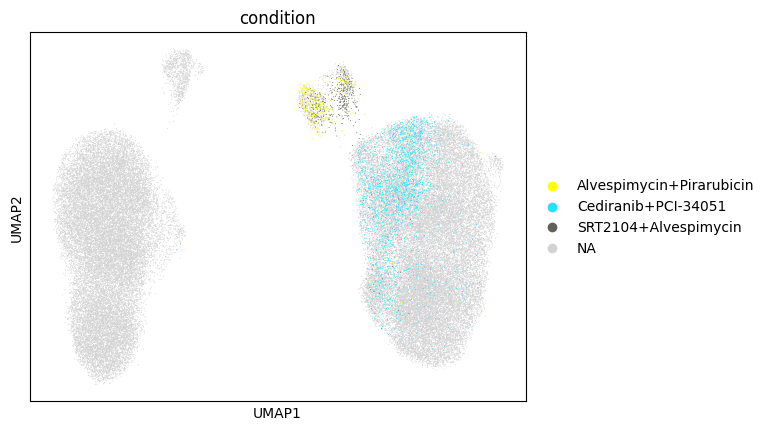

In [43]:
sc.pl.umap(adata_full, color="condition", groups=['Cediranib+PCI-34051', 'SRT2104+Alvespimycin', 'Alvespimycin+Pirarubicin'])

In [48]:
adata_ood.obs["condition"].value_counts()

condition
SRT3025+Cediranib         3016
Givinostat+Dasatinib      2421
control+Dasatinib         2343
Givinostat+SRT1720        2260
Panobinostat+SRT2104      1971
Panobinostat+Dasatinib    1955
Panobinostat+PCI-34051    1814
Name: count, dtype: int64

In [55]:
split = 3
ood_tmp_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood_{split}.h5ad"
adata_ood_tmp = sc.read_h5ad(ood_tmp_path)

In [56]:
adata_ood_tmp.obs["condition"].value_counts()

condition
Panobinostat+Curcumin      2244
Panobinostat+Sorafenib     2013
control+Dacinostat         1869
Panobinostat+SRT1720       1826
Panobinostat+Crizotinib    1641
control+Alvespimycin        758
SRT2104+Alvespimycin        520
control                     500
Name: count, dtype: int64

In [44]:
res = {}
for cond, df in dict_gsea_results.items():
    res[cond] = df.loc['REACTOME_TRANSCRIPTIONAL_REGULATION_BY_TP53']["pval"]

In [45]:
res


{'Alvespimycin+Pirarubicin': 0.0099502485,
 'Cediranib+PCI-34051': 0.013767209,
 'Dacinostat+Danusertib': 0.009049774,
 'Dacinostat+Dasatinib': 0.009124087,
 'Dacinostat+PCI-34051': 0.010958904,
 'Givinostat+Carmofur': 0.004716981,
 'Givinostat+Cediranib': 0.032786883,
 'Givinostat+Crizotinib': 0.0,
 'Givinostat+Curcumin': 0.0,
 'Givinostat+SRT2104': 0.030612245,
 'Givinostat+Sorafenib': 0.0025575447,
 'Givinostat+Tanespimycin': 0.013245033,
 'Panobinostat+Alvespimycin': 0.04694836,
 'Panobinostat+Crizotinib': 0.075987846,
 'Panobinostat+Curcumin': 0.015189873,
 'Panobinostat+SRT1720': 0.022038568,
 'Panobinostat+SRT3025': 0.05929919,
 'Panobinostat+Sorafenib': 0.03583062,
 'SRT2104+Alvespimycin': 0.17307693}

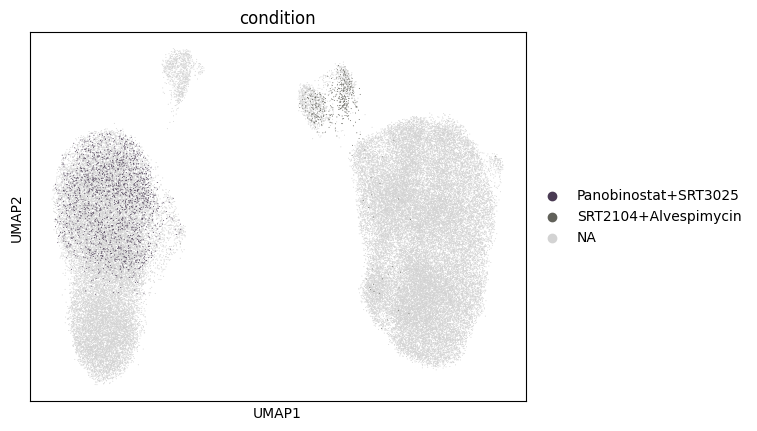

In [47]:
sc.pl.umap(adata_full, color="condition", groups=['SRT2104+Alvespimycin', 'Panobinostat+SRT3025'])

In [157]:
[el for el in adata_train.var_names if "TP" in el] 

['ATP1B3',
 'TP63',
 'TPX2',
 'ATP1B2',
 'PTPRJ',
 'PTPRD',
 'PITPNC1',
 'TPPP3',
 'CTPS1',
 'MCTP1',
 'TPRX1',
 'ATP13A5',
 'GRTP1-AS1',
 'ATP6V1G2-DDX39B']

In [151]:
adata_ood.obs["condition"].value_counts()

condition
Dacinostat+PCI-34051         3298
Givinostat+Cediranib         2783
Givinostat+Curcumin          2736
Panobinostat+SRT3025         1889
control+Panobinostat         1578
Dacinostat+Dasatinib         1231
Panobinostat+Alvespimycin     996
Name: count, dtype: int64

In [111]:
[el for el in gsea_results.index.values if "EGFR" in el]

[]

In [102]:
(
    so.Plot(
        data=(
            gsea_results.head(20).assign(
                **{"-log10(pval)": lambda x: -np.log10(x["pval"])}
            )
        ),
        x="-log10(pval)",
        y="source",
    ).add(so.Bar())
)

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/seaborn/_core/plot.py:1043: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.savefig(buffer, dpi=dpi, format="png", bbox_inches="tight")


KeyboardInterrupt: 